In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import os
import numpy as np

import audiofile
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.tensorboard import SummaryWriter 
import librosa
from IPython.display import Audio

In [2]:
torch.cuda.is_available()

True

In [3]:
class NsynthDataset(Dataset):
  def __init__(self, path, n_fft=2048, hop_length=512, transform=None):
    """
    Args :
      path (string) : Path to the wav files. WARNING : All wav files 
      MUST have same length and same sampling rate.

      n_fft (int) : n_fft option for librosa melspectrogram.

      hop_length (int) : hop_length option for librosa melspectrogram.
    """
    self.path = path
    self.wav_list = os.listdir(path)
    wav_path = os.path.join(self.path,
                            self.wav_list[0])
    wav, sr = audiofile.read(wav_path)
    
    self.sr = sr
    self.wav_len = len(wav)
    self.n_fft = n_fft
    self.hop_length = hop_length

    melspec = melspectrogram(wav, sr, n_fft=self.n_fft, 
                             hop_length=self.hop_length)
    self.n_ts = melspec.shape[0]
    self.n_freqb = melspec.shape[1]

    self.transform = transform

  def __len__(self):
    return len(self.wav_list)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    wav_path = os.path.join(self.path,
                            self.wav_list[idx])
    wav, sr = audiofile.read(wav_path)
    melspec = melspectrogram(wav, sr, n_fft=self.n_fft, 
                             hop_length=self.hop_length)
    if self.transform != None :
      melspec = self.transform(melspec)
  
    return melspec

In [6]:
dataset = NsynthDataset('/fast-1/lemerle/data/nsynth-valid/audio'
                        ,transform=torchvision.transforms.ToTensor())

In [8]:
from model2 import *

In [10]:
os.listdir("trains/train18-11:39:21")

['model-ep0.pth', 'model-ep1.pth']

In [108]:
model_dict = torch.load("trains/train18-11:39:21/model-ep0.pth")
vae = VariationalAutoencoder(256, 1, dataset.n_freqb, dataset.n_ts).to('cuda') # GPU
vae.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

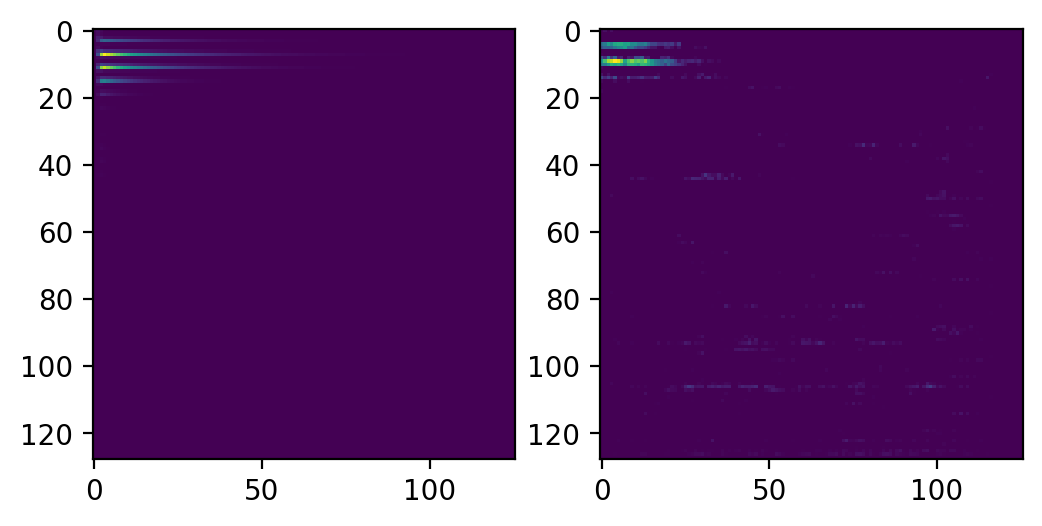

In [134]:
#  Normalisation min-max 
n_max = 17341.379 
n_min = 0

# 
i = int(np.random.randint(10000))
x = (dataset[i] - n_min)/(n_max-n_min)
y = vae(x.unsqueeze(0).to('cuda'))
fig, ax = plt.subplots(1,2)
ax[0].imshow(x[0])
ax[1].imshow(y.to('cpu').detach().numpy()[0][0])

In [135]:
X = x.detach().squeeze().numpy()
Y = y.detach().cpu().squeeze().numpy()

X_gl = librosa.griffinlim(X)
Y_gl = librosa.griffinlim(Y)

Z = Y
Z[Z<10e-3] = 0 #Débruitage manuel

Z_gl = librosa.griffinlim(Z)

In [136]:
Audio(X_gl, rate=16000) #Original

In [137]:
Audio(Z_gl, rate=16000) #Reconstruit + débruité

In [138]:
Audio(Y_gl, rate=16000) #Reconstruit